# [실습] Generative Adversarial Networks 기초

### 학습목표
1. Generative Adversarial Networks(GAN)의 개념에 대해 알아봅니다.

2. GAN의 구조 및 학습 과정을 이해합니다.

## 목차
1. GAN의 개념
2. GAN의 구조 및 학습 과정

## 1. GAN의 개념

GAN은 'Generative Adversarial Network'의 약자로 데이터를 생성하는 생성자(Generator)와 데이터의 진짜, 가짜 여부를 판별하는 판별자(Discriminator)의 두 가지 요소로 구성된 인공지능 모델입니다.

GAN은 2014년 Ian Goodfellow가 NIPS에서 발표했습니다. ([Generative Adversarial Networks (NIPS 2014)](https://arxiv.org/abs/1406.2661)) 이 모델은 두 개의 딥 러닝 네트워크, 생성자(Generator)와 판별자(Discriminator)로 구성되어 있습니다. 생성자는 노이즈를 통해 새로운 데이터를 생성하고, 판별자는 생성된 데이터가 실제 데이터인지 가짜 데이터인지 판별하는 역할을 합니다. 두 네트워크는 함께 학습하며, 생성자는 판별자가 진짜라고 판별할 만큼 **정교한 데이터를 생성**하는 것을 목표로 하고, 판별자는 생성자가 아무리 진짜 같은 데이터를 생성하더라도 **생성된 데이터를 정확하게 가짜로 판별**하는 것을 목표로 합니다.

두 네트워크가 경쟁하면서 학습을 진행하기 때문에 **Adversarial**(적대적)이라는 단어가 붙었습니다.

<center><img src="img/GAN.png" style="width: 1000px"></center>

## 2. GAN의 구조 및 학습

GAN은 위에서 설명했듯이 기본적으로 생성자와 판별자, 두 개의 네트워크로 구성되어 있습니다. 생성자와 판별자의 코드를 직접 작성해 보며 구조를 알아보고 학습과정을 거쳐 이미지를 간단하게 생성해 봅시다.

In [1]:
# 사용할 라이브러리를 import합니다.
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from keras import layers

from IPython import display

### 2.1 데이터 세트
사용하는 데이터 세트는 숫자 손 글씨 데이터 세트인 [MNIST](https://www.tensorflow.org/datasets/catalog/mnist?hl=ko)입니다.

<center><img src="img/mnist-3.0.1.png" style="width: 400px"></center>

In [2]:
# MNIST 데이터 세트를 불러옵니다. 이번 실습에서는 학습 데이터만 사용합니다.
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# 28x28 흑백 이미지 형태로 reshape를 해주고 실수형태로 type을 변경해줍니다.
# 이 과정은 모델 학습에 적합한 형태를 위해 필요합니다.
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
print(train_images.shape)

# 이미지를 [-1, 1]로 정규화합니다.
train_images = (train_images - 127.5) / 127.5

(60000, 28, 28, 1)


In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# 데이터 배치를 만들고 섞습니다.
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

### 2.1 생성자

- `입력` : 생성자는 랜덤한 노이즈를 입력받습니다. 이번 실습에서는 크기가 100인 노이즈를 입력으로 지정해 주겠습니다.
- `출력` : MNIST 데이터는 크기가 28X28이기 때문에 이에 맞춰 생성자의 결과물도 28X28이 되도록 네트워크 구조를 작성해 보겠습니다.

In [4]:
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,))) # z
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7,256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1),
                                    padding="same", use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),
                                     padding="same", use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2),
                                     padding="same", use_bias=False, activation="tanh"))
    assert model.output_shape == (None, 28, 28, 1)

    return model

위에서 작성한 `build_generator()`함수를 사용하여 생성자를 만들고 크기가 100인 무작위 노이즈를 입력값으로 넣어 보도록 하겠습니다. 이 때 생성된 이미지는 학습이 진행되지 않은 초기 생성자의 결과물이기 때문에 숫자 손 글씨 이미지로는 보이지 않을 것입니다.

c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


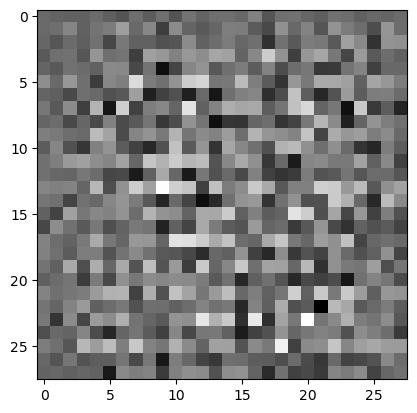

In [5]:
# 생성자를 만듭니다.
generator = build_generator()

# 크기가 100인 무작위 노이즈를 생성하고 생성자에 입력합니다.
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# 생성된 이미지를 확인합니다.
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### 2.2 판별자

- `입력` : 생성된 이미지 또는 실제 이미지를 입력받습니다.
- `출력` : 생성된 이미지일 경우 음수값을, 실제 이미지일 경우 양수값을 출력합니다.

In [6]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

위에서 작성한 `build_discriminator()` 함수에 생성한 이미지(`generage_image`)를 입력하여 결과를 출력합니다. 생성자와 마찬가지로 현재 판별자는 학습되지 않은 상태입니다.

In [7]:
# 판별자를 만듭니다.
discriminator = build_discriminator()

# 생성된 이미지를 판별자에 입력했을 때 결과를 출력합니다.
decision = discriminator(generated_image)
print(decision.numpy())

[[8.4894404e-05]]


c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


판별자에서 반환한 값을 바탕으로 오차역전파를 통해 모델을 학습시키면 어떤 특징에 대해 거짓으로 판별했는지에 대한 정보가 생성자에게 전달되고 이를 토대로 파라미터를 업데이트하며 학습합니다.

아래는 생성자와 판별자에 대한 손실함수입니다.

- **생성자의 손실함수** : 판별자를 얼마나 잘 속였는지를 수치화하여 이를 바탕으로 학습이 이루어지게 됩니다. 생성자는 생성한 이미지를 판별자가 실제 이미지로 판별하는 것을 목표로 합니다.
- **판별자의 손실함수** : 얼마나 정확하게 실제 이미지와 생성된 이미지를 구분하는지를 측정합니다. 판별자는 정확하게 실제 이미지를 '진짜'로 판별하고, 생성된 이미지를 '가짜'로 판별하는 것을 목표로 합니다.

In [8]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [11]:
# 두 개의 모델이 독립적으로 학습하는 것이기 때문에 옵티마이저도 구분하여 사용합니다.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

이제 학습을 진행해 봅시다. 학습이 진행되는 과정을 확인하기 위해 고정된 노이즈(`z`)를 설정합니다.

In [12]:
EPOCHS = 20
noise_dim = 100
num_examples_to_generate = 16

z = tf.random.normal([num_examples_to_generate, noise_dim])

In [13]:
# 학습된 모델을 사용해 이미지를 생성하고 저장합니다.
def generate_and_save_images(model, epoch, test_input):
    # `training`을 False로 설정해 이미지를 생성하는 동안 모델이 학습하지 않도록 합니다.
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")

    plt.savefig("image_at_epoch_{:04d}.png".format(epoch))
    plt.show()

In [14]:
def train_step(images):
    # 랜덤 노이즈를 생성합니다.
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 노이즈를 통해 생성자는 이미지를 생성합니다.
        generated_images = generator(noise, training=True)

        # 판별자는 실제 이미지와 생성된 이미지를 입력받고 판별합니다.
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # 두 네트워크의 loss를 계산합니다.
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )

In [15]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # GIF를 위한 이미지를 바로 생성합니다.
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, z)

    # 마지막 에포크가 끝난 후 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, z)

생성된 이미지를 확인해볼까요? 결과물이 만족스럽지 않다면 epoch 수를 늘리는 방법이 있습니다. 단, 무조건 큰 epoch 수를 정한다고 해서 항상 결과물이 좋은 것은 아니며, 오히려 학습 시간이 오래 걸려 모델 성능이 떨어질 수 있습니다.

In [ ]:
train(train_dataset, EPOCHS)

이번 실습에서는 간단하게 GAN 모델을 구현해보고 결과물을 확인했습니다. 이후 강의를 진행하며 2014년에 발표된 GAN이 어떻게 발전해 왔는지, 어떤 분야에서 활용되는 지 알아봅시다.